In [1]:
import os
import cv2
import pandas as pd
import math
import numpy as np
import warnings
warnings.filterwarnings("ignore")

PIXELS = 1024
DIMENSIONS = np.int16(math.sqrt(PIXELS))

TRAINING_FEATURES_FILE = "csvTrainImages 13440x1024.csv"
TRAINING_LABELS_FILE = "csvTrainLabel 13440x1.csv"
TESTING_FEATURES_FILE = "csvTestImages 3360x1024.csv"
TESTING_LABELS_FILE = "csvTestLabel 3360x1.csv"

def load_data(file=TRAINING_FEATURES_FILE, header=True):
    csv_path = os.path.join("dataset/", file)
    if header:
        return pd.read_csv(csv_path)
    else:
        return pd.read_csv(csv_path, header=None)

In [2]:
data = load_data(TRAINING_FEATURES_FILE)
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.896,0.897,0.898,0.899,0.900,0.901,0.902,0.903,0.904,0.905
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
from matplotlib import pyplot as plt

def imagify(arr, getimage=False, showimage=True):
    img = np.array(np.reshape(arr, (DIMENSIONS, DIMENSIONS)), dtype="uint8")
    if showimage:
        plt.imshow(img, interpolation='nearest')
        plt.gray()
        plt.show() 
        
    if getimage:
        return img

In [4]:
def showimage(img):
    plt.imshow(img, interpolation='nearest')
    plt.gray()
    plt.show() 

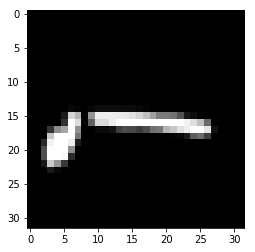

In [5]:
img = imagify(data.values[0], getimage=True)

In [6]:
th1,img1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

127.0


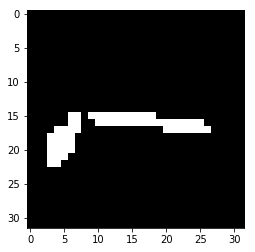

In [7]:
print(th1)
showimage(img1)

In [8]:
th2,img2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

107.0


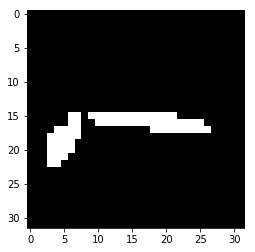

In [9]:
print(th2)
showimage(img2)

In [10]:
blur = cv2.GaussianBlur(img,(5,5),0)
th3,img3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

65.0


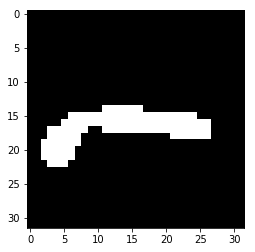

In [11]:
print(th3)
showimage(img3)

In [12]:
THRESH_BINARY = cv2.THRESH_BINARY
THRESH_BINARY_AND_THRESH_OTSU = cv2.THRESH_BINARY+cv2.THRESH_OTSU

In [13]:
def apply_thresholding(df, cap=0, thres=THRESH_BINARY_AND_THRESH_OTSU):
    if thres == None:
        return df
    
    values = df.values
    thres_values = []
    thresholding_started = False
    for value in values:
        img = imagify(value, getimage=True, showimage=False)
        th_,img = cv2.threshold(img,cap,255,thres)
        img = [img.flatten()]
        if thresholding_started:
            thres_values = np.concatenate((thres_values, img), axis=0)
        else:
            thres_values = img
            thresholding_started = True
            
    thres_df = pd.DataFrame(thres_values, columns=df.columns)
    return thres_df

In [14]:
datacopy = data.copy()
data = apply_thresholding(data, thres=THRESH_BINARY_AND_THRESH_OTSU)
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.896,0.897,0.898,0.899,0.900,0.901,0.902,0.903,0.904,0.905
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
from sklearn.decomposition import PCA
import numpy as np

def get_dims_variances(x, min_dim, max_dim, threshold=0.1, capToThreshold=False):
    dims = []
    variances = []
    optimum_dim = min_dim
    saturation_reached = False
    for dim in range(min_dim, max_dim):
        pca = PCA(n_components=dim)
        pca.fit(x)
        variance = np.array(pca.explained_variance_ratio_)
        variance = variance.min()
        if threshold < variance:
            optimum_dim = dim
        else:
            saturation_reached = True
        
        if saturation_reached and capToThreshold:
            break
        else:    
            dims.append(dim)
            variances.append(variance)
        
    return dims, variances, optimum_dim

49


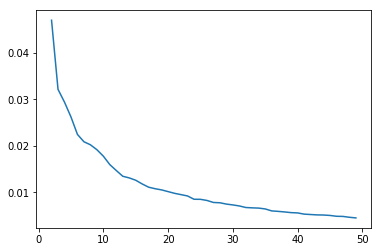

In [16]:
dims, variances, OPTIMUM_DIMENSION = get_dims_variances(data, 2, 50, 1/512, capToThreshold=True)
print(OPTIMUM_DIMENSION)
import matplotlib.pyplot as plt
plt.plot(dims, variances)
plt.show()

In [17]:
dim_var = pd.DataFrame()
dim_var["DIM"] = dims
dim_var["VAR"] = variances

In [18]:
pca = PCA(n_components=OPTIMUM_DIMENSION)
training_features = pca.fit_transform(data)

In [19]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
training_features = imputer.fit_transform(training_features)

In [20]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
training_features = scalar.fit_transform(training_features)

In [21]:
data_labels = load_data(TRAINING_LABELS_FILE)
training_labels = data_labels.values.flatten()

In [32]:
test_data = load_data(TESTING_FEATURES_FILE)
test_data = apply_thresholding(test_data, thres=THRESH_BINARY_AND_THRESH_OTSU)
testing_features = pca.transform(test_data)
testing_features = imputer.transform(testing_features)
testing_features = scalar.transform(testing_features)

In [33]:
test_data_labels = load_data(TESTING_LABELS_FILE)
testing_labels = test_data_labels.values.flatten()

In [34]:
# SGD Classifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

sgd_clf = SGDClassifier(random_state=42)
print("Cross Val Scores on training set\n", cross_val_score(clone(sgd_clf), training_features, training_labels, cv=3, scoring="accuracy"))


sgd_clf.fit(training_features, training_labels)
print("\n\nAccuracy on testing data set\n", sum(testing_labels == sgd_clf.predict(testing_features)) / len(testing_labels))

Cross Val Scores on training set
 [0.20401786 0.21428571 0.21790578]


Accuracy on testing data set
 0.2423340279845192


In [35]:
# KNeighbors Classifier
from sklearn.neighbors import KNeighborsClassifier 

knn_clf = KNeighborsClassifier()
print("Cross Val Scores on training set\n", cross_val_score(clone(knn_clf), training_features, training_labels, cv=3, scoring="accuracy"))

knn_clf.fit(training_features, training_labels)
print("\n\nAccuracy on testing data set\n", sum(testing_labels == knn_clf.predict(testing_features)) / len(testing_labels))

Cross Val Scores on training set
 [0.34084821 0.32700893 0.37419067]


Accuracy on testing data set
 0.4810955641559988


In [36]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier 

forest_clf = RandomForestClassifier(random_state=42)
print("Cross Val Scores on training set\n", cross_val_score(clone(forest_clf), training_features, training_labels, cv=3, scoring="accuracy"))

forest_clf.fit(training_features, training_labels)
print("\n\nAccuracy on testing data set\n", sum(testing_labels == forest_clf.predict(testing_features)) / len(testing_labels))

Cross Val Scores on training set
 [0.29040179 0.29575893 0.30877428]


Accuracy on testing data set
 0.39654659124739505
